# Return Landscapes: `loss-landscapes` for Reinforcement Learning

This example shows how to use the `loss-landscapes` library to plot the landscape of the expected cumulative return of an agent in a reinforcement learning task, as a function of the agent's parameters. The concept is similar to that of a loss landscape in supervised learning: the expected return of the agent on a particular environment changes depending on the parameters of the agent's policy.

The RL setting presents a major challenges. In the case of stochastic environments (and most environments of interest are indeed stochastic), the exact value of the expected return can be obtained by sampling only in the limit of infinite samples. That is, we estimate the expected return by averaging the return attained by the agent over `n` episodes, but the fewer episodes we run, the less confident we are in the accuracy of our estimate.

This notebook considers the expected return landscape of a `DQN` agent in the `CartPole-v1` environment from the OpenAI `gym` framework.

In [11]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# core libraries
import copy
import random
import numpy as np
import gym
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from collections import namedtuple

matplotlib.rcParams['figure.figsize'] = [16, 12]

# code from this library
import loss_landscapes

## 1. The DQN Model

The DQN learning algorithm was first introduced by Mnih et al in their 2013 paper _Playing Atari with Deep Reinforcement Learning_ (https://arxiv.org/abs/1312.5602), in which a DQN agent successfully learned to play classic Atari videogames from raw pixel input. This notebook uses a different neural network structure, as the observation space isn't quite as complex as that of Atari games, but the overall learning algorithm is the same.

Skip to section 2 to see how the `loss-landscapes` library is used.

Replay buffer:

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.next_index = 0
        self.buffer = []

    def __len__(self):
        """
        Returns the number of transition tuples currently stored in the buffer.
        :return: number of stored transitions
        """
        return self.next_index

    def __getitem__(self, index):
        """
        Returns the transition tuple at the given index in the buffer.
        :param index: between 0 and buffer capacity
        :return: item at given index
        """
        return self.buffer[index]

    def push(self, *args):
        """
        Adds a transition tuple to the buffer. If the end of the buffer is reached,
        push starts replacing stored tuples from the beginning of the buffer.
        :param args: elements of the transition tuple
        :return: N/A
        """
        if len(self.buffer) != self.capacity:
            self.buffer.append(Transition(*args))
        else:
            self.buffer[self.next_index] = Transition(*args)
        self.next_index = (self.next_index + 1) % self.capacity

    def sample(self, batch_size):
        """
        Sample uniformly at random a batch of the given size from the replay buffer.
        :param batch_size: number of tuples in the batch
        :return: batch of transition tuples
        """
        return random.sample(self.buffer, batch_size)

Q-function neural network:

In [3]:
class MLP_CartPole(torch.nn.Module):
    """ A simple MLP with dimensions specific to CartPole-v1. """
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(4, 10)
        self.linear_2 = torch.nn.Linear(10, 10)
        self.linear_3 = torch.nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.softmax(self.linear_3(x), dim=0)
        return x

DQN agent:

In [4]:
class DQN:
    def __init__(self, q_function: torch.nn.Module, optimizer, n_actions: int, buf_capacity=10000,
                 learn_delay=1000, batch_size=32, gamma=0.99, epsilon=0.1):
        # core components
        self.q_function = q_function
        self.optimizer = optimizer
        self.target_q_function = copy.deepcopy(self.q_function)
        self.replay_buffer = ReplayBuffer(buf_capacity)

        # hyperparameters
        self.n_actions = n_actions
        self.learn_delay = learn_delay
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon

        # tracking past states for creating transitions in replay buffer
        self.previous_observation = None
        self.previous_action = None

    def act(self, observation):
        return torch.argmax(self.q_function(observation)).item()

    def act_and_train(self, observation, reward):
        # if there is a previous observation/action pair from this episode, update replay buffer
        if self.previous_observation is not None and self.previous_action is not None:
            self.replay_buffer.push(self.previous_observation, self.previous_action, observation, reward)

        # if replay buffer is sufficiently full, train actor and critic
        if len(self.replay_buffer) > self.learn_delay:
            # sample from replay buffer and create prediction targets
            batch = self.replay_buffer.sample(self.batch_size)
            x = torch.tensor([state for state, _, _, _ in batch])
            y = torch.tensor([reward + self.target_q_function(next_state) for _, _, reward, next_state in batch])

            # update critic and actor
            self.optimizer.zero_grad()
            q_loss = F.mse_loss(y - self.q_function(x))
            q_loss.backward()
            self.optimizer.step()

            # soft update of target networks
            transfer_parameters(self.q_function, self.target_q_function, hardness=1)

        # finally, act on the given observation
        if random.random() > self.epsilon:
            action = torch.argmax(self.q_function(observation))
        else:
            action = torch.randint(high=self.n_actions, size=(1,))

        self.previous_observation = observation
        self.previous_action = action
        return action.item()

    def stop_episode(self):
        self.previous_observation = None
        self.previous_action = None

## 2. Training the DQN Agent

The code below follows the standard `gym` training loop as outlined in the OpenAI documentation.

In [5]:
# environment and train settings
env = gym.make('CartPole-v1')
timesteps = 100

# agent
model = MLP_CartPole()
optimizer = optim.Adam(model.parameters())
agent = DQN(model, optimizer, env.action_space.n)

# train
obs, reward, done, info = env.step(agent.act(torch.from_numpy(env.reset()).float()))

for _ in tqdm(range(timesteps), 'Training'):
    # uncomment if you want to watch the environment during training
    # env.render()
    
    if done:
        obs, reward, done, info = env.step(agent.act(torch.from_numpy(env.reset()).float()))
    
    obs, reward, done, info = env.step(agent.act_and_train(torch.from_numpy(obs).float(), reward))

Training: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2380.64it/s]


## 3. Contour Plot of Return Landscape

The `loss-landscapes` library is used in the RL setting in a way very similar to the supervised learning setting; that is, a model or agent is passed to a method such as `loss_landscapes.linear_interpolation` along an `Evaluator`, which defines how the RL agent should be evaluated at a specific point in parameter space.

The complication arising in the RL case is that RL agents are architecturally more complex and varied than supervised learning models. In supervised learning, it is safe to assume that a PyTorch user has a neural network model which, as is standard in Pytorch, inherits the `torch.nn.Module` class. The PyTorch specific aspects of the implementation can therefore assume that the supervised learning model has a `forward` method which returns a tensor, for example.

However, in the case of user-defined RL agents, there is no standard interface to the agents for the `loss-landscapes` library could be programmed to use. The library thus requires that the user specify this interface using an `AgentInterface` object.

In [13]:
from loss_landscapes import AgentInterface
from loss_landscapes.common.evaluators.torch.rl_evaluators import ExpectedReturnEvaluator

DISTANCE = 2000
STEPS = 10

agent_interface = AgentInterface('torch', [agent.q_function], None, lambda a, x: a.act(x))
evaluator = ExpectedReturnEvaluator(env, 4)

# compute loss
exp_returns = loss_landscapes.random_plane(agent, evaluator, agent_interface, DISTANCE, STEPS, 'filter')

Finally, we can use `matplotlib` to draw some usual plots for the collected data:

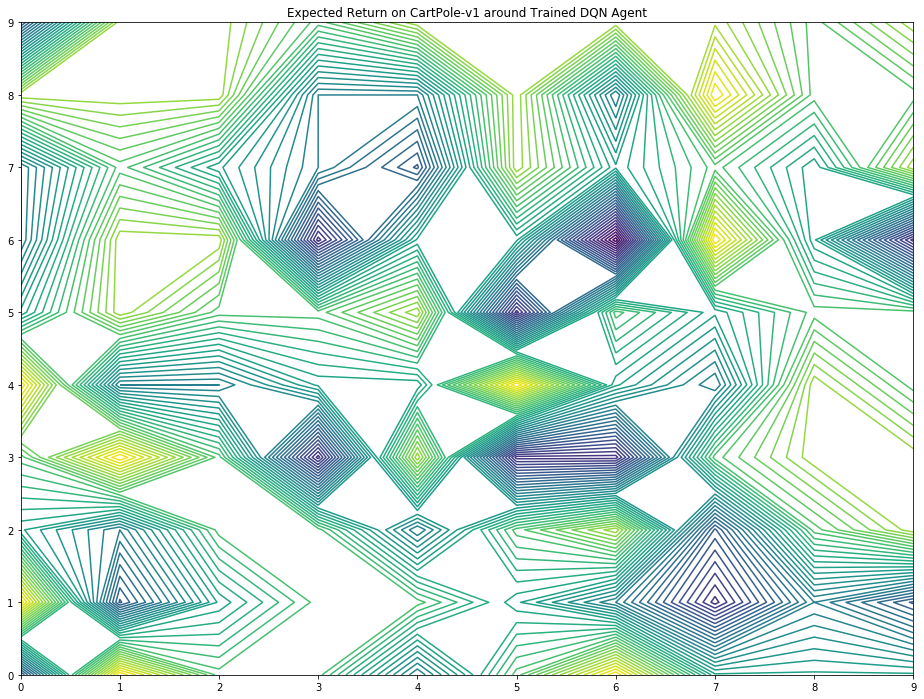

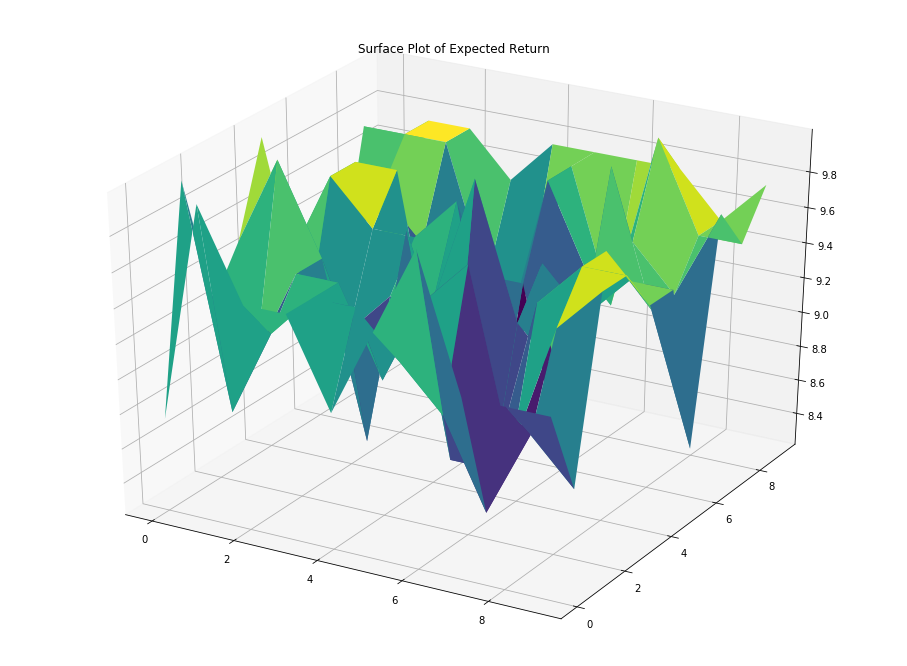

In [14]:
# plot
plt.contour(exp_returns, levels=50)
plt.title('Expected Return on CartPole-v1 around Trained DQN Agent')
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, exp_returns, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Expected Return')
fig.show()